# Outline

## Goal
Solve the SDE:
$$ dX_t = f(X_t)dt + \sigma(X_t)dW_t $$
where:
- $X_t\in\mathbb{R}^n$
- $W_t\in\mathbb{R}^n$ is a Wiener process
- $f:\mathbb{R}^n\to\mathbb{R}^n$
- $\sigma:\mathbb{R}^n\to\mathbb{R}^{n\times n}$

Let $x\mapsto u(x,t)$ be the probability density of $X_t$, from this SDE we can obtain the Fokker-Planck equation:
$$ u_t = \mathcal{L}u = -\sum_{i=1}^n (f_iu)_{x_i} + \frac12\sum_{i,j=1}^n (\Sigma_{i,j}u)_{x_i,x_j} $$
where $\Sigma=\sigma^T\sigma$

The neural network has to approximate the steady state of the Fokker Planck equation. So the function $u$ such that:
$$ \mathcal{L}u=0 , \quad \int_{\mathbb{R}^n} u dx = 1 $$

## Monte Carlo approach

The solution $u$ is the limit of the Fokker-Planck equation ($u = u_\infty$). For this reason we can emulate the SDE:
- given $s_0$
- Using Euler-Maruyama method: $s_{n+1} = s_n + f(s_n)\Delta t+\sigma(s_n) w_n$ where $w_n\sim\mathcal{N}\left(\vec{0},\Delta t\text{Id}\right)$

We apply this method to a large set of starting points $y^{(1)},\ldots, y^{(N^Y)}$

In [22]:
# title: Ornstein-Uhlenbeck 2D

import torch

# model parameters

n: int = 2
# f: Rn -> Rn
def f(Xt: torch.tensor) -> torch.tensor:
    # Xt shape: Sxn
    # ret shape: Sxn
    gamma = 0.5
    return - gamma * Xt

# sigma: Rn -> Rnn
def sigma(Xt: torch.tensor) -> torch.tensor:
    # Xt shape: Sxn
    # ret shape: Sxnxn
    M = torch.tensor([[1.0,2.0],[2.0,1.0]])
    M = M.to(Xt.device)
    return M.expand(Xt.size(0), -1, -1)

# initial condition
X0 = torch.ones(n)

# scheme parameters
NY: int = 1000
T: float = 10
dt: float = 0.01
steps: int = int(T // dt)

# generate white noise with variance dt
w = torch.randn(NY, steps, n) * (dt)**0.5

# matrix to store results
res = torch.zeros(NY, steps, n)

# initial condition
res[:, 0, :] = X0

# time-stepping loop
res = res.cuda()
w = w.cuda()
for i in range(steps - 1):
    # current position
    Xt = res[:, i, :]  # shape: NYxn
    # drift
    drift = f(Xt) * dt  # shape: NYxn
    # diffusion
    diffusion = torch.einsum('nij,nj->ni', sigma(Xt), w[:, i, :])  # shape: NYxn
    # update
    res[:, i + 1, :] = Xt + drift + diffusion


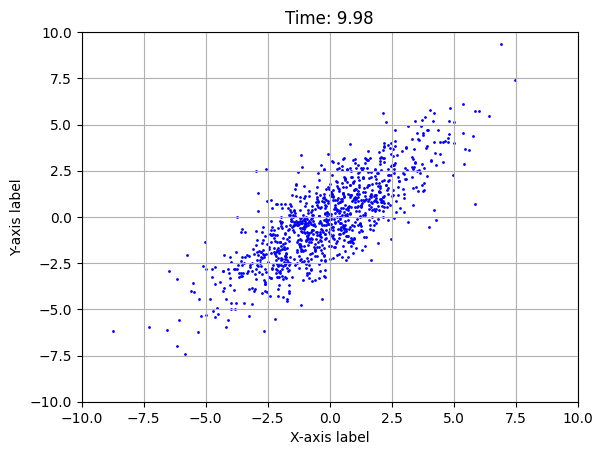

In [23]:
# title: show results
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation  # Import FuncAnimation

res = res.cpu()
res_np = res.numpy()

# plot an animation of points for each step
fig, ax = plt.subplots()
# insert scatter plot
scat = ax.scatter(res_np[:, 0, 0], res_np[:, 0, 1], s=1, color='blue')
# set limits
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# make animation update function
def update(frame):
    scat.set_offsets(res_np[:, frame, :])
    ax.set_title(f'Time: {frame * dt:.2f}')
    return scat,

# create animation
ani = FuncAnimation(fig, update, frames=steps, interval=50)
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Ornstein-Uhlenbeck Process Simulation')
plt.grid()
# save the animation
ani.save('animation.mp4', writer='ffmpeg', fps=100)
plt.show()


# Dataset


# Loss function

$$L(\theta) = \frac{1}{N^X}\sum_{i=1}^{N^X}(\mathcal{L}\tilde{u}(x_i,\theta))^2+\frac{1}{N^Y}\sum_{j=1}^{N^Y}(\tilde{u}(y_j,\theta)-v(y_j))^2:=L_1(\theta)+L_2(\theta)$$

where:
- $\theta$ is the set of parameters of the NN
- $x_i\in\mathbb{R}^n$ with $i=1,2,\ldots,N^X$
- $y_j\in\mathbb{R}^n$ with $j=1,2,\dots,N^Y$
- $v(y_j)$ is the solution of the MC approximation.

# Optimizer

# Architecture

# Training